In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install scikit-surprise

In [ ]:
! pip install fuzzywuzzy

In [37]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
plt.style.use('ggplot')
warnings.filterwarnings(action='ignore')
from fuzzywuzzy import fuzz
from collections import Counter
import re

In [4]:
links = pd.read_csv('/content/drive/MyDrive/동아리/links.csv')
movies = pd.read_csv('/content/drive/MyDrive/동아리/movies.csv')
tags = pd.read_csv('/content/drive/MyDrive/동아리/tags.csv')
ratings = pd.read_csv('/content/drive/MyDrive/동아리/ratings.csv')

### EDA

In [5]:
links.head(3)

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0


In [ ]:
ratings.head(3)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224


In [7]:
movies.head(3)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance


In [9]:
tags.head(3)

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992


In [6]:
links['movieId'].nunique()

9742

In [ ]:
links['imdbId'].nunique()

9742

<Axes: >

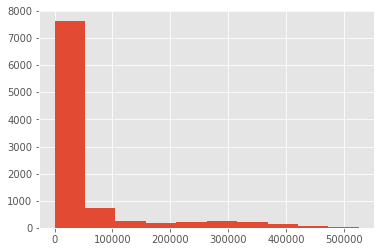

In [ ]:
links['tmdbId'].hist()

In [8]:
arr = []
for i in range(len(movies)):
    arr += movies['genres'][i].split('|')

In [ ]:
movie_genres = set(arr) # 영화 장르 리스트트
movie_genres

{'(no genres listed)',
 'Action',
 'Adventure',
 'Animation',
 'Children',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'IMAX',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western'}

In [33]:
tags['tag'].unique()

array(['funny', 'Highly quotable', 'will ferrell', ..., 'gun fu',
       'heroic bloodshed', 'Heroic Bloodshed'], dtype=object)

In [38]:
tags['tag'] = [re.sub('[^A-Za-z]', ' ', s).lower() for s in tags['tag']]

In [40]:
tagdict=  dict(Counter(tags['tag'].unique()))

<function matplotlib.pyplot.show(close=None, block=None)>

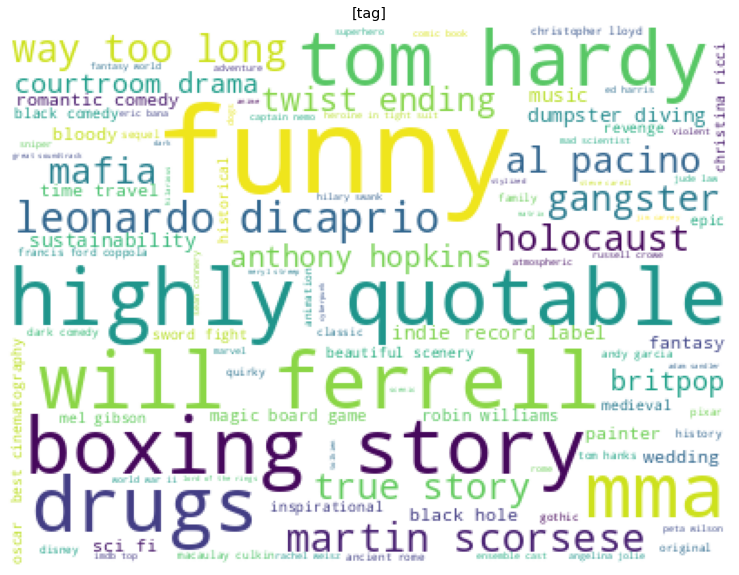

In [43]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
wc = WordCloud(background_color='white', max_words=100, width = 400, height = 300)

plt.figure(figsize = (15,10))

plt.title('[tag]')
count_dic = tagdict
cloud = wc.generate_from_frequencies(count_dic)
plt.axis('off')
plt.imshow(cloud)


plt.show

### SVD

In [30]:
from surprise import Reader, Dataset
from surprise import SVD
from surprise import KNNBasic
from surprise import accuracy 
from surprise.model_selection import train_test_split, cross_validate

In [26]:
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

In [27]:
train, test = train_test_split(data, test_size=0.25, random_state=0)

In [28]:
model = SVD()
model.fit(train)

In [29]:
# 성능 평가
predictions = model.test(test)
accuracy.rmse(predictions)
accuracy.mse(predictions)

RMSE: 0.8695
MSE: 0.7561


0.7560759876702025

### knnbasic

In [31]:
knn = KNNBasic(k=40, min_k=1, sim_options={'name': 'msd', 'user_based': True}, random_state=0)
knn.fit(train)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [32]:
# 성능 평가
predictions = knn.test(test)
accuracy.rmse(predictions)
accuracy.mse(predictions)

RMSE: 0.9447
MSE: 0.8924


0.8923843483466474

### knn CF

In [18]:
df = pd.merge(ratings.drop('timestamp', axis=1), movies.drop('genres', axis=1), how='outer', on='movieId') [['movieId','userId','rating']].sort_values(by=['movieId']).fillna(0)

In [19]:
from scipy.sparse import csr_matrix
 
# pivot ratings into movie features
df_movie_features = ratings.pivot(
    index='movieId',
    columns='userId',
    values='rating'
).fillna(0)
 
# convert dataframe of movie features to scipy sparse matrix
mat_movie_features = csr_matrix(df_movie_features.values)

In [20]:
from sklearn.neighbors import NearestNeighbors
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)

In [21]:
movie_user_mat = df.pivot(index='movieId', columns='userId', values='rating').fillna(0)
# create mapper from movie title to index
movie_to_idx = {
    movie: i for i, movie in 
    enumerate(list(movies.set_index('movieId').loc[movie_user_mat.index].title))
}
# transform matrix to scipy sparse matrix
movie_user_mat_sparse = csr_matrix(movie_user_mat.values)

In [22]:
model_knn.fit(movie_user_mat_sparse)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=20)

In [23]:
def fuzzy_matching(mapper, fav_movie, verbose=True):

    match_tuple = []
    # get match
    for title, idx in mapper.items():
        ratio = fuzz.ratio(title.lower(), fav_movie.lower())
        if ratio >= 60:
            match_tuple.append((title, idx, ratio))
    # sort
    match_tuple = sorted(match_tuple, key=lambda x: x[2])[::-1]
    if not match_tuple:
        print('Oops! No match is found')
        return
    if verbose:
        print('Found possible matches in our database: {0}\n'.format([x[0] for x in match_tuple]))
    return match_tuple[0][1]

def make_recommendation(model_knn, data, mapper, fav_movie, n_recommendations):
    # fit
    model_knn.fit(data)
    # get input movie index
    print('You have input movie:', fav_movie)
    idx = fuzzy_matching(mapper, fav_movie, verbose=True)
    print('idx is', idx)
    # inference
    print('Recommendation system start to make inference')
    print('......\n')
    distances, indices = model_knn.kneighbors(data[idx], n_neighbors=n_recommendations+1)
    # get list of raw idx of recommendations
    raw_recommends = \
        sorted(list(zip(indices.squeeze().tolist(), distances.squeeze().tolist())), key=lambda x: x[1])[:0:-1]
    # get reverse mapper
    reverse_mapper = {v: k for k, v in mapper.items()}
    # print recommendations
    print('Recommendations for {}:'.format(fav_movie))
    for i, (idx, dist) in enumerate(raw_recommends):
        print('{0}: {1}, with distance of {2}'.format(i+1, reverse_mapper[idx], dist))

In [24]:
my_favorite = 'Iron Man'

make_recommendation(
    model_knn=model_knn,
    data=movie_user_mat_sparse,
    fav_movie=my_favorite,
    mapper=movie_to_idx,
    n_recommendations=10)

You have input movie: Iron Man
Found possible matches in our database: ['Iron Man (1931)', 'Iron Man (2008)', 'Iron Man 3 (2013)', 'Iron Man 2 (2010)']

idx is 9444
Recommendation system start to make inference
......

Recommendations for Iron Man:
1: Iron Man 2 (2010), with distance of 0.8378452406436285
2: Deadpool (2016), with distance of 0.8287028225431171
3: Captain America: The First Avenger (2011), with distance of 0.8284499215114449
4: Thor (2011), with distance of 0.8100078666989077
5: Iron Man 3 (2013), with distance of 0.8084347429557697
6: Easy A (2010), with distance of 0.8012997197858369
7: 21 Jump Street (2012), with distance of 0.8012997197858369
8: Ex Machina (2015), with distance of 0.7914855859429253
9: Avengers: Age of Ultron (2015), with distance of 0.7903430326556163
10: Iron Man & Hulk: Heroes United (2013), with distance of 0.0


### MF 신경망

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dot, Add, Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, Adamax

In [6]:
ratings_train, ratings_test = train_test_split(ratings, test_size=0.2, shuffle=True, random_state=42)

In [7]:
ratings.head(3)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224


In [8]:
# 잠재요인의 수 지정
K = 200

mu = ratings_train.rating.mean()

# ratings 의 max 값에 +! >> bias 텀 크기 1을 고려하는것?
M = ratings.userId.max() + 1
N = ratings.movieId.max() + 1

def RMSE(y_true, y_pred) :
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

In [9]:
user = Input(shape=(1,))
item = Input(shape=(1,))

P_embedding = Embedding(M,K,embeddings_regularizer=l2())(user)
Q_embedding = Embedding(N,K,embeddings_regularizer=l2())(item)

user_bias = Embedding(M,1,embeddings_regularizer=l2())(user)
item_bias = Embedding(N,1,embeddings_regularizer=l2())(item)

In [10]:
R = layers.dot([P_embedding,Q_embedding], axes=(2,2)) # (2,2) 첫번째랑 두번째 몇번째 축끼리 연산 할건지 -> K 끼리 연산하겠다
R = layers.add([R, user_bias,item_bias])
R = Flatten()(R) # 차원 1차원으로 변환하겠다.

model = Model(inputs=[user,item],outputs=R)
model.compile(
    loss=RMSE,
    optimizer=SGD(),
    metrics = [RMSE]
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 200)       122200      ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 200)       38722000    ['input_2[0][0]']                
                                                                                              

In [11]:
result = model.fit(
    x = [ratings_train.userId.values,
        ratings_train.movieId.values],
    y = ratings_train.rating.values - mu,
    
    epochs = 30,
    validation_data = (
        [ratings_train.userId.values,
        ratings_train.movieId.values],
        ratings_train.rating.values - mu
    )
)

Epoch 1/30
2521/2521 [==============================] - 50s 17ms/step - loss: 205.9870 - RMSE: 1.0216 - val_loss: 119.6850 - val_RMSE: 1.0123
Epoch 2/30
2521/2521 [==============================] - 43s 17ms/step - loss: 75.7776 - RMSE: 1.0076 - val_loss: 44.2981 - val_RMSE: 1.0031
Epoch 3/30
2521/2521 [==============================] - 42s 16ms/step - loss: 28.2821 - RMSE: 1.0003 - val_loss: 16.8001 - val_RMSE: 0.9988
Epoch 4/30
2521/2521 [==============================] - 41s 16ms/step - loss: 10.9582 - RMSE: 0.9975 - val_loss: 6.7699 - val_RMSE: 0.9966
Epoch 5/30
2521/2521 [==============================] - 42s 17ms/step - loss: 4.6386 - RMSE: 0.9956 - val_loss: 3.1112 - val_RMSE: 0.9954
Epoch 6/30
2521/2521 [==============================] - 42s 17ms/step - loss: 2.3338 - RMSE: 0.9949 - val_loss: 1.7767 - val_RMSE: 0.9947
Epoch 7/30
2521/2521 [==============================] - 42s 17ms/step - loss: 1.4930 - RMSE: 0.9944 - val_loss: 1.2899 - val_RMSE: 0.9944
Epoch 8/30
2521/2521 [===

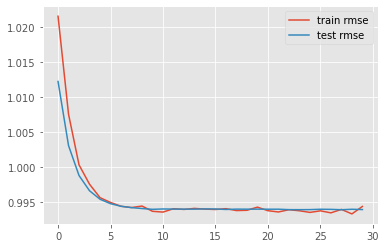

In [12]:
import matplotlib.pyplot as plt
plt.plot(result.history['RMSE'], label = "train rmse")
plt.plot(result.history['val_RMSE'], label = "test rmse")
plt.legend()
plt.show()

In [14]:
user_ids = ratings_test.userId.values[0:6]
movie_ids = ratings_test.movieId.values[0:6]
predictions = model.predict([user_ids,movie_ids])+mu

1/1 [==============================] - 0s 193ms/step


In [15]:
print(ratings_test[0:6]) # test res

       userId  movieId  rating   timestamp
67037     432    77866     4.5  1335139641
42175     288      474     3.0   978465565
93850     599     4351     3.0  1498524542
6187       42     2987     4.0   996262677
12229      75     1610     4.0  1158989841
7433       51      177     4.0  1230930634
